In [52]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]

In [93]:
# for f in glob.glob('nse/*.csv'):
#     print(f)
l = sorted(os.listdir('nse'))
for f in l:
    print(f)

2011.csv
2012.csv
2013.csv
2014.csv
2015.csv
2016.csv
2017.csv
2018.csv
2019.csv


In [97]:
# Config options
cwd = 'nse'

In [98]:
nifty = pd.concat([pd.read_csv(cwd + '/' + f) for f in sorted(os.listdir(cwd))], ignore_index = True)

In [99]:
nifty.describe()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
count,2157.000000,2157.000000,2157.000000,2157.000000,2.157000e+03,2157.000000
mean,7888.824200,7926.308530,7838.329694,7882.328581,2.010675e+08,9130.983635
std,2108.947982,2110.800172,2100.736612,2105.622145,9.692724e+07,4529.455523
min,4623.150000,4623.150000,4531.150000,4544.200000,6.555703e+06,297.890000
25%,5837.950000,5874.200000,5798.150000,5840.550000,1.405172e+08,6069.120000
50%,7959.850000,7992.000000,7922.800000,7954.900000,1.757243e+08,7819.050000
75%,9755.750000,9818.300000,9714.400000,9765.550000,2.309406e+08,10837.200000
max,12052.650000,12103.050000,12005.850000,12088.550000,7.411532e+08,35131.190000


In [100]:
nifty.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,03-Jan-2011,6177.45,6178.55,6147.20,6157.60,96028639,4477.36
1,04-Jan-2011,6172.75,6181.05,6124.40,6146.35,181727905,7678.55
2,05-Jan-2011,6141.35,6141.35,6062.35,6079.80,139614193,6606.21
3,06-Jan-2011,6107.00,6116.15,6022.30,6048.25,152338978,7050.18
4,07-Jan-2011,6030.90,6051.20,5883.60,5904.60,171809106,8325.79


In [101]:
nifty["52 week high"] = pd.Series.rolling(nifty.High, window=200, min_periods=1).max()
nifty["52 week low"] = pd.Series.rolling(nifty.Low, window=200, min_periods=1).min()

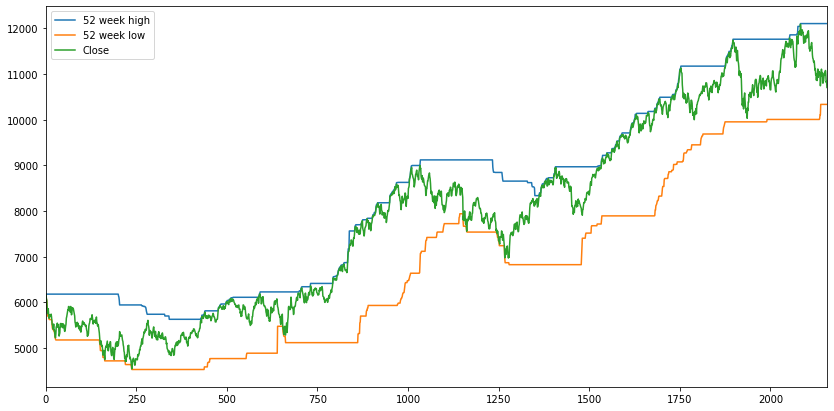

In [105]:
nifty[["52 week high", "52 week low", "Close"]].plot()
# nifty[["High"]].plot()

In [106]:
highs = (nifty["52 week high"] == nifty.High).value_counts()
print("Fraction of times market is at highs:", highs[True]/(highs[True] + highs[False]))
lows = (nifty["52 week low"] == nifty.Low).value_counts()
print("Fraction of times market is at lows:", lows[True]/(lows[True] + lows[False]))

Fraction of times market is at highs: 0.09457579972183588
Fraction of times market is at lows: 0.022253129346314324
